# 9.6. Implementação concisa de redes neurais recorrentes

Esta seção mostrará como implementar o mesmo modelo de linguagem de forma mais eficiente usando a API de alto nível fornecida pela sua estrutura de aprendizado profundo. Começamos, como antes, carregando o conjunto de dados The Time Machine .

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 9.6.1. Definindo o modelo

Definimos a seguinte classe usando a RNN implementada por APIs de alto nível.

In [3]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)                         # API de alto nível. Substitui a classe RNNScratch

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

Herdando da RNNLMScratch classe da Seção 9.5, a RNNLM classe a seguir define um modelo de linguagem completo baseado em RNN. Observe que precisamos criar uma camada de saída separada totalmente conectada.

In [4]:
class RNNLM(d2l.RNNLMScratch):                                              # Substitui a classe RNNLMScratch, que agora é classe pai.   
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)                        # camada de saída totalmente conectada.

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)                          # usada para trocar dois eixos (ou dimensões) de um array

# 9.6.2. Treinamento e Previsão

Antes de treinar o modelo, vamos fazer uma predição com um modelo inicializado com pesos aleatórios. Dado que não treinamos a rede, ela gerará predições sem sentido.

In [9]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hastttuuuuuuuuuuuuuuuuu'

Em seguida, treinamos nosso modelo, aproveitando a API de alto nível.

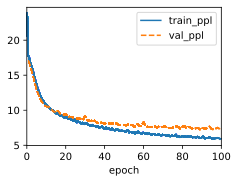

In [10]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Comparado com a Seção 9.5 , este modelo atinge perplexidade comparável, mas roda mais rápido devido às implementações otimizadas. Como antes, podemos gerar tokens previstos seguindo a string de prefixo especificada.

In [13]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the ment the th'

In [14]:
#----------------------------------------------------------------------------------------------------
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')
device = torch.device('cpu')
model = model.to(device)    


X, y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()               # loss

7.556187629699707

# 9.6.3. Resumo

APIs de alto nível em frameworks de aprendizado profundo fornecem implementações de RNNs padrão. Essas bibliotecas ajudam você a evitar perda de tempo reimplementando modelos padrão. Além disso, implementações de frameworks são frequentemente altamente otimizadas, levando a ganhos significativos de desempenho (computacional) quando comparadas com implementações do zero.

# Código Agrupado

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#----------------------------------------------------------------------------------------------------

class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)                         # API de alto nível. Substitui a classe RNNScratch

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

#----------------------------------------------------------------------------------------------------

class RNNLM(d2l.RNNLMScratch):                                              # Substitui a classe RNNLMScratch, que agora é classe pai.   
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)                        # camada de saída totalmente conectada.

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)                          # usada para trocar dois eixos (ou dimensões) de um array

#----------------------------------------------------------------------------------------------------

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

#----------------------------------------------------------------------------------------------------

trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

#----------------------------------------------------------------------------------------------------

model.predict('it has', 20, data.vocab, d2l.try_gpu())

#----------------------------------------------------------------------------------------------------

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')
device = torch.device('cpu')
model = model.to(device)    

X, y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()               # loss


# 9.6.4. Exercícios

# Ex. 1 - Você pode fazer o modelo RNN superajustar usando APIs de alto nível?

Yes, you can intentionally design an RNN model to overfit using high-level APIs like PyTorch or TensorFlow. Overfitting occurs when a model learns to perform exceptionally well on the training data but fails to generalize to unseen data because it memorizes the training examples rather than learning the underlying patterns.  To make an RNN model overfit, you can do the following:

- Create a Complex Model: Design an RNN architecture with a large number of parameters.
- Use Insufficient Training Data
- Train for Many Epochs: Train the model for an excessive number of epochs.
- Remove Regularization: Avoid using regularization techniques like dropout, L1 or L2 regularization.
- Disable Data Augmentation

# Ex. 2 - Implemente o modelo autorregressivo da Seção 9.1 usando uma RNN.

O código abaixo está errado. Não é possível aproveitar a classe RNNLM. Necessário criar classe específica para este problema.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

#----------------------------------------------------------------------------------------------------
batch_size=16

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)       #  cria sequência de 1 até 1000.
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2   # cria a onda senoidal + ruido.

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]      # Sendo tau=600. Tem-se 600 listas com tensores com 400 elementos
        self.features = torch.stack(features, 1)                                 # converte as listas para um tensor(400,600)
        self.labels = self.x[self.tau:].reshape((-1, 1))                         # tensor (400,1)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

#----------------------------------------------------------------------------------------------------

class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)                         # API de alto nível. Substitui a classe RNNScratch

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

#----------------------------------------------------------------------------------------------------

class RNNLM(d2l.RNNLMScratch):                                              # Substitui a classe RNNLMScratch, que agora é classe pai.
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)                        # camada de saída totalmente conectada.

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)                          # usada para trocar dois eixos (ou dimensões) de um array

#----------------------------------------------------------------------------------------------------

data = Data()
# d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

rnn = RNN(num_inputs=batch_size, num_hiddens=32)
model = RNNLM(rnn, vocab_size=batch_size, lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

#----------------------------------------------------------------------------------------------------

# model.predict('it has', 20, data.vocab, d2l.try_gpu())

#----------------------------------------------------------------------------------------------------



# Outras respostas:

https://pandalab.me/archives/concise_implementation_of_recurrent_reural_networks

# Referências:

https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNNCell

https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html